# Injecting Simulated Satellites to Quantify Dwarf Search Sensitivity in DP0

In [1]:
import os
import sys
sys.path.append(os.path.expandvars('$HOME/software/simple_adl'))
sys.path.append(os.path.expandvars('$HOME/software/'))
import glob
import yaml
import time
from IPython.core.debugger import set_trace

import numpy as np
import pandas as pd
from pandas import *
from scipy import stats
from scipy.optimize import curve_fit

import healpy as hp
import healsparse as hsp
import skyproj
import fitsio as fits

import matplotlib.pyplot as plt
#plt.rcParams.update({"text.usetex": True, "font.family": "serif"})
import seaborn as sns

from astropy import units as u
from astropy.coordinates import SkyCoord

import simple_adl.survey
import simple_adl.isochrone
from simple_adl.coordinate_tools import distanceModulusToDistance, angsep
from simple_adl.search import write_output, search_by_distance, cut_isochrone_path

from lsst.rsp import get_tap_service
import dc2_satellite_census.code.utils as sc_utils
import dc2_satellite_census.code.selection_function as selection_function

import importlib

## Plotting

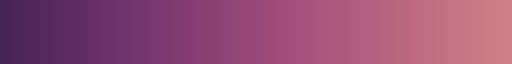

In [2]:
#cmap = sns.cubehelix_palette(start=1.0, rot=-1.0, light=0.8, dark=0.2, hue=1.0, reverse=True, as_cmap=True)
cmap = sns.cubehelix_palette(start=3.0, rot=0.5, light=0.6, dark=0.2, hue=1.0, reverse=True, as_cmap=True)
#cmap = sns.cubehelix_palette(start=0.0, rot=0.0, light=0.7, dark=0.3, hue=1.0, reverse=True, as_cmap=True)
#cmap = sns.cubehelix_palette(start=0.5, rot=0.0, light=0.7, dark=0.3, hue=1.0, reverse=True, as_cmap=True)

cmap

In [3]:
def gnomic(mu_ra, mu_dec, ra, dec):
    """
    https://mathworld.wolfram.com/GnomonicProjection.html
    The Gnomic projection is a conformal (angle-preserving) map of 
    coordinates on a sphere to coordinates on a plane around some central
    coordinate.
    """
    mu_ra = np.deg2rad(mu_ra)
    mu_dec = np.deg2rad(mu_dec)
    ra = np.deg2rad(ra)
    dec = np.deg2rad(dec)
    
    cos_c = np.sin(mu_dec) * np.sin(dec) + np.cos(mu_dec) * np.cos(dec) * np.sin(ra - mu_ra)
    x = np.cos(dec) * np.sin(ra - mu_ra) / cos_c
    y = (np.cos(mu_dec) * np.sin(dec) - np.sin(mu_dec) *np.cos(dec) * np.cos(ra - mu_ra)) / cos_c
    
    return x, y

In [4]:
def plot_cmd(data, axs):
    """Plots a color magnitude diagram.
    
    Inputs:
        data (pd.DataFrame): DataFrame with photometry data
        axs: pyplot axes object
    """
    y = data['mag_g']  
    x = data['mag_g'] - data['mag_r']
    
    xlims = [-1, 1.5]  #need to find better way to restrict axes
    ylims = [16,28]
    axs.set_xlim(xlims); 
    axs.set_ylim(ylims); 
    
    axs.set_ylabel('$Magnitude (g)$')
    axs.set_xlabel('$Color (g-r)$')
    
    axs.plot(x, y, 'ko', markersize=0.3, alpha=0.3)
    axs.invert_yaxis()

    
    plt.show()
    
    return

In [5]:
def plot_cmd_sep(rdata, sdata, axs):
    """Plots a color magnitude diagram with simulated satellite objects highlighted.
    
    rdata (pd.DataFrame): background field photometry data
    sdata (pd.DataFrame): simulated satellite photometry data
    axs: pyploy axes object
    """
    y = rdata['mag_g']  
    x = rdata['mag_g'] - rdata['mag_r']
    
    xlims = [-0.5, 1]
    ylims = [16,27]
    axs.set_xlim(xlims); 
    axs.set_ylim(ylims); 
    
    axs.set_ylabel('$g$')
    axs.set_xlabel('$g-r$')
    
    n, x, y, p = axs.hist2d(x, y, cmap='Greys', bins=[np.linspace(-0.5, 1, 50), np.linspace(16, 27, 50)], label='DC2 object', norm=LogNorm(vmax=1000))
    plt.colorbar(p, label='Number of objects')
    y = sdata['mag_g']  
    x = sdata['mag_g'] - sdata['mag_r']
    axs.plot(x, y, 'o', color='red',  markersize=5, alpha=1, label='satellite star', markeredgecolor='white', mew=0.5)
    axs.invert_yaxis()
    axs.legend(markerscale=1)
    
    plt.show()
    
    return

In [6]:
def plot_cmd_sep_iso(data, iso_selection, axs):
    """Plots a color magnitude diagram, highlighting objects that pass isochrone selection.
    
    data (pd.DataFrame): photometry data
    iso_selection: isochrone to be applied to the data
    axs: pyplot axes object
    """
    source = data[iso_selection]
    data = data[~iso_selection]
    y = data['mag_g']  
    x = data['mag_g'] - data['mag_r']
    
    xlims = [-0.5, 1]
    ylims = [16,27]
    axs.set_xlim(xlims); 
    axs.set_ylim(ylims); 
    
    axs.set_ylabel('$g$')
    axs.set_xlabel('$g-r$')
    
    n, x, y, p = axs.hist2d(x, y, cmap='Greys', bins=[np.linspace(-0.5, 1, 50), np.linspace(16, 27, 50)], label='DC2 object', norm=LogNorm(vmax=1000))
    plt.colorbar(p, label='Number of objects')
    y = source['mag_g']  
    x = source['mag_g'] - source['mag_r']
    axs.plot(x, y, 'o', color='red',  markersize=3, alpha=1, label='isochrone object', markeredgecolor='white', mew=0.5, rasterized=True)
    axs.invert_yaxis()
    axs.legend(markerscale=1)
    
    #plt.show()
    
    return

In [7]:
def draw_mu_vs_ng24(mu,ng24,color,data=None,**kwargs):
    """ Draw one surface brightness (mu) vs the number of stars with g < 24 (N_g24)

    Parameters
    ----------
    mu    : recarray of surface brightness
    ng22  : recarray of N(g < 24)
    color : recarray of color values
    kwargs: passed to matplotlib.scatter

    Returns
    -------
    ax0, ax1 : the axes of the figure produced
    """

    defaults = dict(vmin=0., vmax=20, s=5, alpha=1.0)
    #kwargs = utils.setdefaults(kwargs,defaults)

    ax0 = plt.gca()

    ax0.set_xscale('log')
    c1 = ax0.scatter(ng24,mu,c=color,
                     rasterized=True,edgecolor='none')

    kwargs = dict(facecolor='none',alpha=1.0,hatch='x',edgecolor='0.5',lw=1)

    # DIFFICULTY = 1
    ax0.fill_between([5,8e5],[39,26],[48,48],**kwargs)
    ax0.text(1e3,40,'DIFFICULTY=1',fontsize=18)

    # DIFFICULTY = 2
    ax0.fill_between([6e1,8e5],[10,10],[23.5,23.5],**kwargs)
    ax0.text(2e3,20,'DIFFICULTY=2',fontsize=18)

    ax0.set_xticks([10,100,1000,1e4,1e5])
    ax0.set_xticklabels(['10^1','10^2','10^3','10^4','10^5'],
                        fontsize=16)
    ax0.set_yticks([15,20,25,30,35,40])
    ax0.set_yticklabels([15,20,25,30,35,40],fontsize=16)

    ax0.set_xlim(5.5,5e5)
    ax0.set_ylim(14,42)

    return ax0, c1

In [8]:
def plot_mu_vs_ng24(sims,data=None):
    """ Plot surface brightness (mu) vs the number of stars with g < 24 (N_g24)

    Parameters
    ----------
    sims : recarray of simulated satellite properties

    Returns
    -------
    axs : the axs of the figure produced
    """
    fig,axs = plt.subplots(figsize=(6,6))

    sel = (sims['N_G24'] > 5)

    mu = sims['SURFACE_BRIGHTNESS'][sel]
    ng24 = sims['N_G24'][sel]
    sig = sims['SIG'][sel]

    # simple
    plt.sca(axs)
    _,c1 = draw_mu_vs_ng24(mu,ng24,sig)
    # y-label
    axs.set_ylabel('$\mu [mag arcsec^{-2}]$',fontsize=18,labelpad=8)
    axs.set_xlabel('N(g < 24)',fontsize=18,labelpad=8)
    axs.set_xlim(5*1e0, 1e6)
    # Colorbar
    cbar_ax = fig.add_axes([0.93, 0.1075, 0.0175, 0.78])
    cbar2 = plt.colorbar(c1, cax=cbar_ax, ticks=[0,5,10,15,20,25,30,35])
    cbar2.ax.set_yticklabels([0,5,10,15,20,25,30,35], fontsize=12)
    cbar2.set_label('SIG',size=18,labelpad=6)
    cbar2.solids.set_rasterized(True)
    cbar2.solids.set_edgecolor("face")

    return axs

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_722/4003380198.py:24: SyntaxWarning: invalid escape sequence '\m'
  axs.set_ylabel('$\mu [mag arcsec^{-2}]$',fontsize=18,labelpad=8)


In [9]:
def plots(position, real_data, sim_data, merged_data, cmap):
    '''
    Plots the objects from DC2 data, the sim satellite data, and DC2+sim data
    on separate plots. Also plots a color magnitude diagram.
    
    Inputs:
        position (tuple(ra, dec)): position of the object
        real_data (pd.DataFrame): DC2 data at position
        sim_data (pd.DataFrame): simulated satellite data
        merged_data (pd.DataFrame): DC2 data + sim data
        cmap (): color map to use for plots
    '''
    
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))
    
    hb = axs[0].hexbin(*gnomic(*position, real_data['ra'], real_data['dec']), mincnt=1, cmap=cmap, gridsize=50)
    cb = fig.colorbar(hb, ax=axs[0])
    # axs[0].scatter(0, 0, c='r', marker='+', s=200)
    axs[0].set_title('DC2 Data')
    axs[0].set_xlabel(r'$x$')
    axs[0].set_ylabel(r'$y$')

    hb = axs[1].hexbin(*gnomic(*position, sim_data['ra'], sim_data['dec']), mincnt=1, cmap=cmap, gridsize=50)
    cb = fig.colorbar(hb, ax=axs[1])
    # axs[1].scatter(0, 0, c='r', marker='+', s=200)
    axs[1].set_title(f'Simulated Satellite {mcid}')
    axs[1].set_xlabel(r'$x$')
    axs[1].set_ylabel(r'$y$')

    hb = axs[2].hexbin(*gnomic(*position, merged_data['ra'], merged_data['dec']), mincnt=1, cmap=cmap, gridsize=50)
    cb = fig.colorbar(hb, ax=axs[2])
    # axs[2].scatter(0, 0, c='r', marker='+', s=200)
    axs[2].set_title('Merged')
    axs[2].set_xlabel(r'$x$')
    axs[2].set_ylabel(r'$y$')

    plot_cmd(merged_data, axs[3])
    plt.show()

In [10]:
def gen_contours(mbins, rbins, dmin, dmax, pdet, survey):
    # contour expects bin centers                                                                                        
    mcent = (mbins[:-1]+mbins[1:])/2.
    rcent = (rbins[:-1]+rbins[1:])/2.
    CS = plt.contour(mcent,rcent,pdet.T,levels=[0.50],
                     colors='r',linstyles='dashed',linewidths=0.5)

    data = CS.allsegs[0][0]
    #plt.scatter(data[:,0],data[:,1],c='k',s=3)                                                                          
    outfile= '%s_p50_d%06.2f.npy'%(survey,np.sqrt(dmin*dmax))
    print("Writing %s..."%outfile)
    np.save(outfile,data)

In [11]:
def setdefaults(kwargs,defaults):
    for k,v in defaults.items():
        kwargs.setdefault(k,v)
    return kwargs

In [12]:
def draw_survey(dist,survey,**kwargs):
    defaults = dict(ls='--',color='k',zorder=1)
    kwargs = setdefaults(kwargs,defaults)
    abs_mag, r_physical,a,b,c = calc_survey(dist,survey)
    sel = abs_mag < b
    plt.plot(abs_mag[sel],r_physical[sel],**kwargs)

In [13]:
def calc_survey(dist,survey='lsst'):
    
    mbins = np.arange(-11,2.5,0.75)

    if survey == 'des':
        #    Dist   A0     Mv0    logr0
        P0=[[11.3 ,  21.5,   7.8 ,   3.8],
            [22.6 ,  24.1,   8.3 ,   4.2],
            [45.2 ,  17.2,   5.2 ,   4.3], #tuned
            [90.5 ,  8.6 ,   1.2 ,   4.1],
            [181.0,  6.6 ,   -1.1,   4.1],
            [362.0,  6.3 ,   -2.3,   4.3]]

    elif survey == 'ps1':
        #    Dist      A0     Mv0    logr0
        P0=[[11.3 ,  21.7,   6.7 ,   3.9],
            [22.6 ,  16.4,   4.3 ,   4.0],
            [45.2 ,  11.5,   1.0 ,   4.0],
            [90.5 ,  8.6 ,   -1.0,   4.0],
            [181.0,  7.2 ,   -2.4,   4.2],
            [362.0,  4.2 ,   -4.8,   4.0]]
        P0=[[11.3 ,  22.8 ,  7.1  ,  4.0],
            [22.6 ,  19.0 ,  5.0  ,  4.1],
            [45.2 ,  14.1 ,  1.8  ,  4.2],
            [90.5 ,  11.0 ,  -0.3 ,  4.3],
            [181.0,  7.5  ,  -2.2 ,  4.2],
            [362.0,  6.8  ,  -4.0 ,  4.4],]
    
    elif survey=='lsst_true':
        #    Dist      A0     Mv0    logr0
        P0=[[11.3 ,  22.7 ,  10.0 ,  4.0  ],
            [22.6 ,  24.7 ,  10.0 ,  4.3  ],
            [45.2 ,  25.1 ,  8.7  ,  4.7  ],
            [90.5 ,  24.4 ,  7.6  ,  5.0  ],
            [181.0,  11.0 ,  3.2  ,  4.4  ],
            [362.0,  8.6  ,  0.2  ,  4.7  ]]

    elif survey=='lsst_measured':
        #    Dist      A0     Mv0    logr0
        P0=[[11.3 ,  22.4 ,  10.0 ,  3.9  ],
            [22.6 ,  25.3 ,  10.0 ,  4.3  ],
            [45.2 ,  31.6 ,  9.9  ,  4.9  ],
            [90.5 ,  21.5 ,  6.6  ,  4.8  ],
            [181.0,  9.0  ,  1.9  ,  4.3  ],
            [362.0,  4.1  ,  -1.2 ,  3.9  ]]
        
    elif survey=='lsst_corrected':
        #    Dist   A0     Mv0    logr0
        P0=[[11.3 ,  25.0 ,  10.0 ,  4.0  ],
            [22.6 ,  30.8 ,  10.0 ,  4.6  ],
            [45.2 ,  20.7 ,  6.9  ,  4.4  ],
            [90.5 ,  23.4 ,  5.8  ,  5.0  ],
            [181.0,  14.3 ,  2.1  ,  4.8  ],
            [362.0,  6.5  ,  -1.4 ,  4.3  ]]



    #A = normalization factor (how curved)
    #B = Mv0 -- the absolute magnitude cut
    #C = R0  -- the r_physical cut
    PARAMS = np.rec.fromrecords(P0,names=['D','A','B','C'])

    a = np.interp(dist,PARAMS['D'],PARAMS['A'])
    b = np.interp(dist,PARAMS['D'],PARAMS['B'])
    c  = np.interp(dist,PARAMS['D'],PARAMS['C'])

    abs_mag = np.linspace(mbins.min(),mbins.max(),1000)
    r_physical = a/(abs_mag - b) + c

    return abs_mag, r_physical, a, b, c

In [14]:
def plot_osf(sims: pd.DataFrame, title: str, save: bool = False, out_name: str = None, 
             contours: bool = False, survey: str = None, threshold: float = 5.5) -> None:
    """
    Plot the observational selection function
    
    parameters: 
        sims: sims dataframe
        title: title for the plot
        save: flag to save figure or not
        out_name: name of the output file if saved
        gen_contours: flag to generate 50% detection efficiency contours
        survey: survey name for efficiency contours
        
    returns: None
    """
    # bins in distance
    dbins = 2**np.arange(3,10)
    # bins in absolute magnitude
    mbins = np.arange(-11,2.5,0.75)
    # bins in physical radius
    rbins = np.arange(0,3.75,0.3)

    fig,axes = plt.subplots(2,3,figsize=(12,7))
    plt.subplots_adjust(wspace=0, hspace=0)
    axes[0,0].axes.get_xaxis().set_visible(False)
    axes[0,1].axes.get_yaxis().set_visible(False)
    axes[0,2].axes.get_yaxis().set_visible(False)
    axes[1,2].axes.get_yaxis().set_visible(False)
    axes[1,1].axes.get_yaxis().set_visible(False)
    for i,(dmin,dmax) in enumerate(zip(dbins[:-1],dbins[1:])):
        plt.sca(axes.flat[i])
        plt.xlabel("$M_v$", fontsize=15)
        plt.ylabel("$log_{10}$(r/pc)", fontsize=15)
        plt.text(-10, 0.5, "%i < D < %i kpc"%(dmin,dmax), fontsize=9, )
        plt.xlim(-10.25,1.75)
        plt.ylim(0, 3.3)
        if i == 1:
            plt.title(title, fontsize=15)
        s = sims[(sims['DISTANCE'] >= dmin)&(sims['DISTANCE'] < dmax)]

        det = s["SIG"] >= threshold

        total = np.histogram2d(s['ABS_MAG'],np.log10(s['R_PHYSICAL']*1e3),
                           bins=[mbins,rbins])[0]
        ndet = np.histogram2d(s['ABS_MAG'],np.log10(s['R_PHYSICAL']*1e3),
                           weights=det,bins=[mbins,rbins])[0]

        pdet = ndet.astype(float)/total
        im = plt.pcolormesh(mbins,rbins,pdet.T,rasterized=True)
        draw_survey(np.sqrt(dmin*dmax), survey='des', color='black')
        draw_survey(np.sqrt(dmin*dmax), survey='lsst_true', color='red', lw=2)
        draw_survey(np.sqrt(dmin*dmax), survey='lsst_measured', color='red', ls='-.', alpha=0.8)
        #draw_survey(np.sqrt(dmin*dmax), survey='lsst_corrected', color='red', ls= ':', alpha=0.6)
        if contours:
            gen_contours(mbins, rbins, dmin, dmax, pdet, survey=survey)

    cb = fig.colorbar(im, ax=axes.ravel().tolist(), label='Detection Efficiency')
    
    if save:
        plt.savefig(out_name)
    
    return

## Load data from RSP TAP

In [15]:
from lsst.rsp import get_tap_service

service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

/tmp/ipykernel_722/4062763552.py:3: DeprecationWarning: get_tap_service() is deprecated, use get_tap_service("tap")
  service = get_tap_service()


In [16]:
# Note that this query (which uses the truth information about star--galaxy separation) is much slower
def query_RSP_truth(service, ra, dec, radius=1):
    """Return data queried from Rubin TAP using true star-galaxy separation
    Parameters
    ----------
    service : TAP service [str]
    ra      : Right Ascension [deg]
    dec     : Declination [deg]
    radius  : radius around (ra, dec) [deg]

    Returns
    -------
    df (pd.Dataframe): data from Rubin TAP
    """
    # Redenning coefficients
    R_g = 3.185
    R_r = 2.140
    R_i = 1.571
    
    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg

    query = f"""
        SELECT
            obj.ra, obj.dec,
            obj.mag_g, obj.mag_r,
            obj.magerr_g, obj.magerr_r,
            obj.mag_g - {R_g} as mag_corrected_g, obj.mag_r - {R_r} as mag_corrected_r,
            obj.extendedness as extended_class
        FROM dp01_dc2_catalogs.object as obj
        JOIN dp01_dc2_catalogs.truth_match as truth
        ON truth.match_objectId = obj.objectId
        WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        AND truth.match_objectId >= 0 
        AND truth.is_good_match = 1
        AND truth.truth_type = 2
    """
    
    df = service.search(query).to_table().to_pandas()
    df['MC_SOURCE_ID'] = 0
    
    return df

In [17]:
def query(service, ra, dec, radius=1.0, gmax=23.5):
    """Return data queried from Rubin TAP
    Parameters
    ----------
    service : TAP service [str]
    ra      : Right Ascension [deg]
    dec     : Declination [deg]
    radius  : radius around (ra, dec) [deg]

    Returns
    -------
    good_results : pd.Dataframe
    """

    # Redenning coefficients
    R_g = 3.185
    R_r = 2.140
    R_i = 1.571
    
    # Define our reference position on the sky and cone radius in arcseconds
    # to use in all following examples
    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg
    
    # Quality selection and star--galaxy separation adapted from
    # https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_pandas_stellar_locus.ipynb

    snr_threshold = 5
    mag_err_threshold = 1/snr_threshold
    mag_threshold =26

    # assuming extendedness is the same in all bands we assume g_extendedness matches extendedness for dp0.2 tables
    
    safe_max_extended = 1.0
    
    query = f"""
        SELECT
            ra, dec,
            mag_g, mag_r,
            magerr_g, magerr_r,
            mag_g - {R_g} AS mag_corrected_g,
            mag_r - {R_r} AS mag_corrected_r,
            extendedness
        FROM dp01_dc2_catalogs.object
        WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        AND extendedness < {str(safe_max_extended)}
    """

    job = service.submit_job(query)
    job.run()
    job.wait(phases=['COMPLETED', 'ERROR'])
    async_results = job.fetch_result()
    results = async_results.to_table().to_pandas()
    job.delete()

    good_snr = (results['magerr_g'] < mag_err_threshold) & (results['magerr_r'] < mag_err_threshold)
    good_results = results[good_snr]
    
    return good_results

## Prepare simulated satellites

In [18]:
def get_catalog_file(catalog_dir, mc_source_id):
    """
    Inputs:
        catalog_dir = string corresponding to directory containing the stellar catalog infiles
        mc_source_id = integer corresponding the target MC_SOURCE_ID value
    Outputs:
        catalog_infile = string corresponding to filename of stellar catalog containing mc_source_id
    """
    catalog_infiles = sorted(glob.glob(catalog_dir + '/*catalog*.fits'))
    mc_source_id_array = []
    catalog_infile_index_array = []
    for ii, catalog_infile in enumerate(catalog_infiles):
        mc_source_id_min = int(os.path.basename(catalog_infile).split('.')[0].split('mc_source_id_')[-1].split('-')[0])
        mc_source_id_max = int(os.path.basename(catalog_infile).split('.')[0].split('mc_source_id_')[-1].split('-')[1])
        assert (mc_source_id_max > mc_source_id_min) & (mc_source_id_min >= 1), 'Found invalue MC_SOURCE_ID values in filenames'
        mc_source_id_array.append(np.arange(mc_source_id_min, mc_source_id_max + 1))
        catalog_infile_index_array.append(np.tile(ii, 1 + (mc_source_id_max - mc_source_id_min)))

    mc_source_id_array = np.concatenate(mc_source_id_array)
    catalog_infile_index_array = np.concatenate(catalog_infile_index_array)

    assert len(mc_source_id_array) == len(np.unique(mc_source_id_array)), 'Found non-unique MC_SOURCE_ID values in filenames'
    assert np.in1d(mc_source_id, mc_source_id_array), 'Requested MC_SOURCE_ID value not among files'
    mc_source_id_index = np.nonzero(mc_source_id == mc_source_id_array)[0][0] # second [0] added by smau 7/23/18 to fix incompatiable type bug
    return catalog_infiles[catalog_infile_index_array[mc_source_id_index]]

In [19]:
def load_sim_data(sim_dir, mc_source_id):
    """
    Load info for injecting satellite sims
    """
    cat_file = get_catalog_file(sim_dir, mc_source_id)
    cat_fits = fits.FITS(cat_file)
    w = cat_fits[1].where(f'MC_SOURCE_ID == {mc_source_id}')
    try:       
        data = cat_fits[1][w]
        cat_fits.close()
        return data
    except IndexError: 
        print(f'NO SIM DATA, {mc_source_id} NOT FOUND')
        return None

In [20]:
def load_simdf(catalog_dir: str, results_dir: str) -> pd.DataFrame:
    """
    Combines information from the sim catalog files and the results directory to build the sims dataframe for results plots.
    
    parameters:
        catalog_dir: directory with the sim catalogs
        results_dir: directory with sim search results 
        
    returns:
        sims: sims dataframe
    """
    population_file = glob.glob(os.path.join(catalog_dir, '*population*'))
    files = glob.glob(os.path.join(results_dir, '*.csv'))
    first_file = files[0]
    sim_pop = fits.read(population_file[0])
    sim_pop = sim_pop.byteswap().newbyteorder() 
    df1 = pd.DataFrame(sim_pop)
    file_ids = [files[8:23] for files in os.listdir(results_dir) if 'ipynb' not in files]
    for i,f in enumerate(population_file):
        if i == 0:
            continue
        for ids in file_ids:
            if ids in f:
                sim_pop = fits.read(f)
                sim_pop = sim_pop.byteswap().newbyteorder()
                df2 = pd.DataFrame(sim_pop)
                df1 = pd.concat((df1,df2), ignore_index=True)
                break

    datadf = read_csv(first_file)
    for f in files:
        if f == first_file:
            continue
        df3 = read_csv(f)
        datadf = pd.concat((datadf, df3), ignore_index=True)

    sims = pd.merge(df1,datadf[['MC_SOURCE_ID','SIG']],on='MC_SOURCE_ID',how='left')         #merge
    sims = sims[sims['FRACDET_CORE'] == 1]
    sims = sims[sims['FRACDET_WIDE'] == 1]
    sims = sims[sims['FRACDET_HALF'] == 1]
    sims.loc[sims.DIFFICULTY == 2, 'SIG'] = 37.5
    
    return sims

## Main loop over simulated satellites per position

In [22]:
sim_dir = '/project/shared/data/satsim/lsst_dc2_v6'
population_file = glob.glob(os.path.join(sim_dir, '*population*'))

In [24]:
search_times = []
for i, file in enumerate(population_file):
    if i==20:
        break
    name = file
    start = name.find('0')
    end = start + 15
    mcids = name[start:end]
    print(mcids)
    #outfile = f'07_sims_v7_final_mag_cut/sim_pop_{mcids}.csv'
    #if os.path.exists(f'results_dir/{outfile}'):
    #    print(f'Files {outfile} already processed')
    #    continue

    with open('config.yaml') as ymlfile:
        cfg = yaml.load(ymlfile, Loader=yaml.SafeLoader)
        survey = simple_adl.survey.Survey(cfg)

    sim_population = fits.read(file)
    sim_positions = np.unique(sim_population[['RA', 'DEC']])
    sim_population  = sim_population.byteswap().newbyteorder()    # resetting byte order for compatibility
    sim_population = sim_population[sim_population['FRACDET_CORE'] == 1]
    sim_population = sim_population[sim_population['FRACDET_WIDE'] == 1]
    sim_population = sim_population[sim_population['FRACDET_HALF'] == 1]
    radius = 2

    for iii,position in enumerate(sim_positions):
        sim_population_at_position = sim_population[sim_population[['RA', 'DEC']] == position]
        t = pd.DataFrame(sim_population_at_position)
        if len(t['MC_SOURCE_ID'].values) == 0:
            print(f'No sims at {position}')
            continue
        print(f'Querying region {position}')
        real_data = query(service, position[0], position[1], radius)  # pd.DataFrame

        print('Satellites at ', position, ':\n', t['MC_SOURCE_ID'].values)
        for mcid in sim_population_at_position['MC_SOURCE_ID']:
            sim_data = load_sim_data(sim_dir, mcid)
            if sim_data is not None:
                sim_data = sim_data.byteswap().newbyteorder()   # resetting byte order for compatibility
                sim_data = pd.DataFrame(sim_data)               # convert to pd.DataFrame
                # mask to ensure we only use sims within the queried data's footprint

                c2 = SkyCoord(sim_data['ra'], sim_data['dec'], unit='deg', frame='icrs')
                center = SkyCoord(position[0], position[1], unit='deg')
                d2d = center.separation(c2) 
                catalogmsk = d2d < radius*u.deg
                sim_data = sim_data[catalogmsk]

                if sim_data.empty:
                    print(f'No sim data to inject into region at ({position[0]},{position[1]}) after applying mask')
                    continue

                # merging the sims and dc2 data
                frames = [real_data[real_data.columns[:-1]], sim_data[real_data.columns[:-1]]]
                merged_data = pd.concat(frames)  # pd.Dataframe
                # perform mag cut on the merged data
                good_snr = (merged_data['magerr_g'] < 0.2) & (merged_data['magerr_r'] < 0.2)
                merged_data = merged_data[good_snr]
                good_mag = (merged_data['mag_g'] < survey.catalog['mag_max']) & (merged_data['mag_r'] < survey.catalog['mag_max'])
                merged_data = merged_data[good_mag]
                
                plots(position, real_data, sim_data, merged_data, cmap)

                print('Searching for: MC_SOURCE_ID ', mcid)

                ra = position[0]
                dec = position[1]
                region = simple_adl.survey.Region(survey, ra, dec)
                region.data = merged_data

                # Scan in distance moduli    
                distance_modulus = t.loc[t['MC_SOURCE_ID'] == mcid]['DISTANCE_MODULUS']
                distance_modulus = distance_modulus.values[0]
                iso_search = simple_adl.isochrone.Isochrone(survey=survey.isochrone['survey'],
                                                       band_1=survey.band_1.lower(),
                                                       band_2=survey.band_2.lower(),
                                                       age=12.0, #survey.isochrone['age'],
                                                       metallicity=0.00010, #survey.isochrone['metallicity'],
                                                       distance_modulus=distance_modulus)

                iso_selection = cut_isochrone_path(region.data[survey.mag_dered_1], 
                                                      region.data[survey.mag_dered_2],
                                                      region.data[survey.mag_err_1],
                                                      region.data[survey.mag_err_2],
                                                      iso_search,
                                                      survey.catalog['mag_max'],
                                                      radius=0.1)
                
                start = time.time()
                results = search_by_distance(survey, region, distance_modulus, iso_selection) 
                end = time.time()
                search_times.append(end-start)
                ra_peak_array, dec_peak_array, r_peak_array, sig_peak_array, distance_modulus_array, n_obs_peak_array, n_obs_half_peak_array, n_model_peak_array = np.asarray(results)
                best_ra_peak, best_dec_peak, best_r_peak, best_distance_modulus, n_obs_peak, n_obs_half_peak, n_model_peak, best_sig_peak = 0, 0, 0, 0, 0, 0, 0, 0

                if mcid: 
                    mc_source_id_array = np.full_like(distance_modulus_array, mcid)
                else:
                    mc_source_id_array = np.zeros(len(distance_modulus_array))

                # Sort peaks according to significance
                index_sort = np.argsort(sig_peak_array)[::-1]
                ra_peak_array = ra_peak_array[index_sort]
                dec_peak_array = dec_peak_array[index_sort]
                r_peak_array = r_peak_array[index_sort]
                sig_peak_array = sig_peak_array[index_sort]
                distance_modulus_array = distance_modulus_array[index_sort]
                n_obs_peak_array = n_obs_peak_array[index_sort]
                n_obs_half_peak_array = n_obs_half_peak_array[index_sort]
                n_model_peak_array = n_model_peak_array[index_sort]
                mc_source_id_array = mc_source_id_array[index_sort]

                # Collect overlapping peaks
                for ii in range(0, len(sig_peak_array)):
                    if sig_peak_array[ii] < 0:
                        continue
                    sep = angsep(ra_peak_array[ii], dec_peak_array[ii], ra_peak_array, dec_peak_array)
                    sig_peak_array[(sep < r_peak_array[ii]) & (np.arange(len(sig_peak_array)) > ii)] = -1.

                # Prune the list of peaks
                ra_peak_array = ra_peak_array[sig_peak_array > 0.]
                dec_peak_array = dec_peak_array[sig_peak_array > 0.]
                r_peak_array = r_peak_array[sig_peak_array > 0.]
                distance_modulus_array = distance_modulus_array[sig_peak_array > 0.]
                n_obs_peak_array = n_obs_peak_array[sig_peak_array > 0.]
                n_obs_half_peak_array = n_obs_half_peak_array[sig_peak_array > 0.]
                n_model_peak_array = n_model_peak_array[sig_peak_array > 0.]
                mc_source_id_array = mc_source_id_array[sig_peak_array > 0.]
                sig_peak_array = sig_peak_array[sig_peak_array > 0.] # Update the sig_peak_array last!

                if sig_peak_array[0] > best_sig_peak:
                    best_sig_peak = sig_peak_array[0]
                    best_ra_peak = ra_peak_array[0]
                    best_dec_peak = dec_peak_array[0]
                    best_r_peak = r_peak_array[0]
                    best_distance_modulus = distance_modulus_array[0]
                    n_obs_peak = n_obs_peak_array[0]
                    n_obs_half_peak = n_obs_half_peak_array[0]
                    n_model_peak = n_model_peak_array[0]
                    mc_source_id = mc_source_id_array[0]

                del merged_data
                
                for ii in range(0, len(sig_peak_array)):
                    print('{:0.2f} sigma; (RA, Dec) = ({:0.2f}, {:0.2f}); r = {:0.2f} deg; d = {:0.1f}, mu = {:0.2f} mag, mc_source_id: {:0.2f}'.format(sig_peak_array[ii], 
                             ra_peak_array[ii], 
                             dec_peak_array[ii], 
                             r_peak_array[ii],
                             distanceModulusToDistance(distance_modulus_array[ii]),
                             distance_modulus_array[ii],
                             mc_source_id_array[ii]))  

                if best_sig_peak < 5.5:
                    print(f'--> {mcid} NOT FOUND')
                    print('---------------------------------')
                    try:
                        if (len(sig_peak_array) > 0):
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center, best_ra_peak, best_dec_peak,
                                            best_r_peak, best_distance_modulus, 
                                            n_obs_peak, n_obs_half_peak, n_model_peak, 
                                            best_sig_peak, mcid, 0, outfile)
                        else:
                            print('No significant hotspots found.')
                            nan_array = [np.nan]
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center,
                                             nan_array, nan_array, nan_array, nan_array, 
                                             nan_array, nan_array, nan_array, nan_array,
                                             [mc_source_id], 0, outfile)
                    except Exception as e: 
                        print(e)
                        print('Data missing, cannot write to file')

                else:   
                    print(f'--> {mcid} FOUND')
                    print('---------------------------------')
                    try:
                        if (len(sig_peak_array) > 0):
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center, best_ra_peak, best_dec_peak,
                                            best_r_peak, best_distance_modulus, 
                                            n_obs_peak, n_obs_half_peak, n_model_peak, 
                                            best_sig_peak, mcid, 0, outfile)
                        else:
                            print('No significant hotspots found.')
                            nan_array = [np.nan]
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center,
                                             nan_array, nan_array, nan_array, nan_array, 
                                             nan_array, nan_array, nan_array, nan_array,
                                             [mc_source_id], 0, outfile)
                    except Exception as e: 
                        print(e)
                        print('Data missing, cannot write to file')

0027301-0027400
Querying region (55.223614, -38.647755)


KeyboardInterrupt: 

### search using range of distance modulus

0027301-0027400
Querying region (55.223614, -38.647755)
Satellites at  (55.223614, -38.647755) :
 [27381 27383 27384 27386 27387 27389 27390]


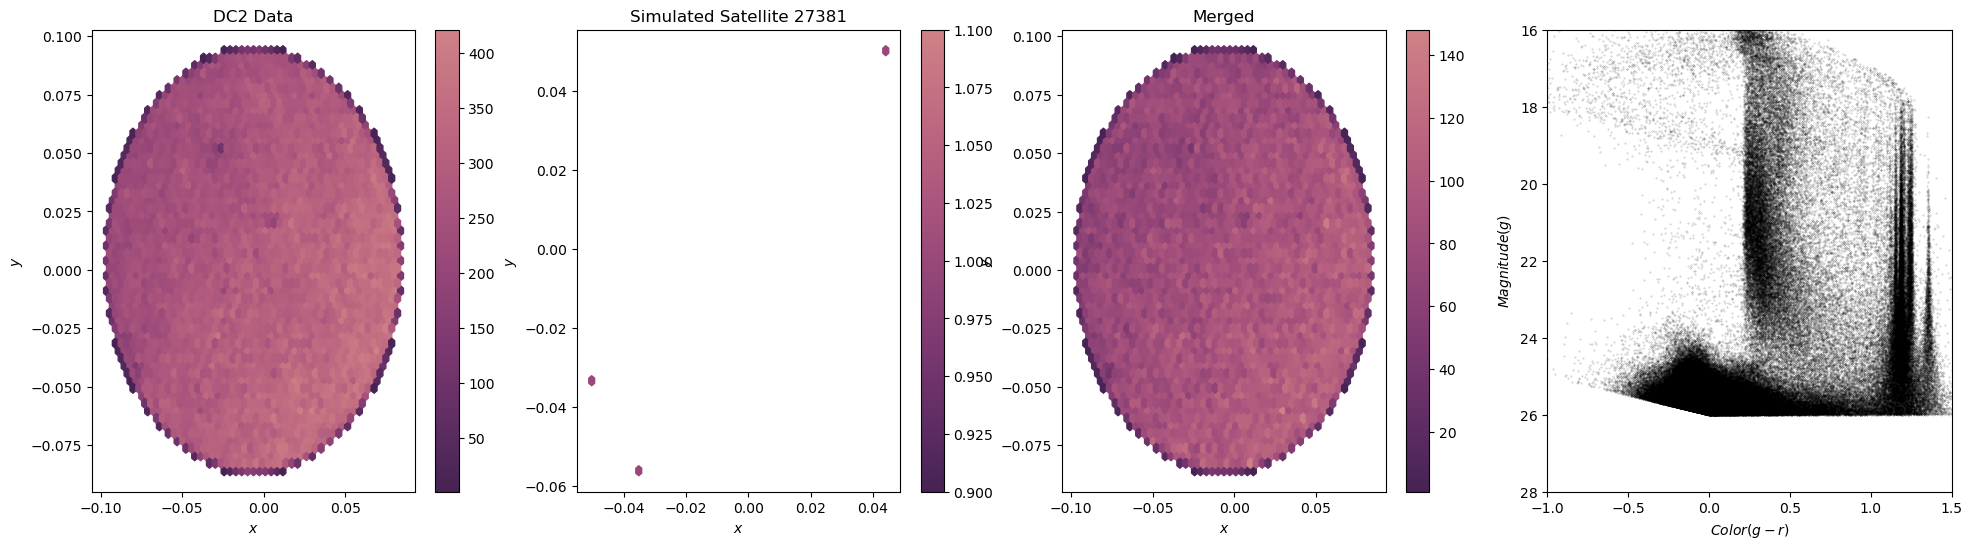

Searching for: MC_SOURCE_ID  27381
Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1514.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -1.235, y_peak:        0.025, r_peak:        0.050, sig:        2.778, ra_peak:       53.643, dec_peak:      -38.612
Fitting aperture to hotspot...
Characteristic density local = 1462.2 deg^-2 = 0.406 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:       -0.165, r_peak:        0.040, sig:        3.225, ra_peak:       53.895, dec_peak:      -38.805
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.035, r_peak:        0.030, sig:        3.694, ra_peak:       54.397, dec_peak:      -38.680
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.945, r_peak:        0.030, sig:        3.048, ra_peak:       54.958, dec_p

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (20, 8) + inhomogeneous part.

In [24]:
search_times = []
for i, file in enumerate(population_file):
    if i==20:
        break
    name = file
    start = name.find('0')
    end = start + 15
    mcids = name[start:end]
    print(mcids)
    #outfile = f'07_sims_v7_final_mag_cut/sim_pop_{mcids}.csv'
    #if os.path.exists(f'results_dir/{outfile}'):
    #    print(f'Files {outfile} already processed')
    #    continue

    with open('config.yaml') as ymlfile:
        cfg = yaml.load(ymlfile, Loader=yaml.SafeLoader)
        survey = simple_adl.survey.Survey(cfg)

    sim_population = fits.read(file)
    sim_positions = np.unique(sim_population[['RA', 'DEC']])
    sim_population  = sim_population.byteswap().newbyteorder()    # resetting byte order for compatibility
    sim_population = sim_population[sim_population['FRACDET_CORE'] == 1]
    sim_population = sim_population[sim_population['FRACDET_WIDE'] == 1]
    sim_population = sim_population[sim_population['FRACDET_HALF'] == 1]
    radius = 2

    for iii,position in enumerate(sim_positions):
        sim_population_at_position = sim_population[sim_population[['RA', 'DEC']] == position]
        t = pd.DataFrame(sim_population_at_position)
        if len(t['MC_SOURCE_ID'].values) == 0:
            print(f'No sims at {position}')
            continue
        print(f'Querying region {position}')
        real_data = query(service, position[0], position[1], radius)  # pd.DataFrame

        print('Satellites at ', position, ':\n', t['MC_SOURCE_ID'].values)
        for mcid in sim_population_at_position['MC_SOURCE_ID']:
            sim_data = load_sim_data(sim_dir, mcid)
            if sim_data is not None:
                sim_data = sim_data.byteswap().newbyteorder()   # resetting byte order for compatibility
                sim_data = pd.DataFrame(sim_data)               # convert to pd.DataFrame
                # mask to ensure we only use sims within the queried data's footprint

                c2 = SkyCoord(sim_data['ra'], sim_data['dec'], unit='deg', frame='icrs')
                center = SkyCoord(position[0], position[1], unit='deg')
                d2d = center.separation(c2) 
                catalogmsk = d2d < radius*u.deg
                sim_data = sim_data[catalogmsk]

                if sim_data.empty:
                    print(f'No sim data to inject into region at ({position[0]},{position[1]}) after applying mask')
                    continue

                # merging the sims and dc2 data
                frames = [real_data[real_data.columns[:-1]], sim_data[real_data.columns[:-1]]]
                merged_data = pd.concat(frames)  # pd.Dataframe
                # perform mag cut on the merged data
                good_snr = (merged_data['magerr_g'] < 0.2) & (merged_data['magerr_r'] < 0.2)
                merged_data = merged_data[good_snr]
                good_mag = (merged_data['mag_g'] < survey.catalog['mag_max']) & (merged_data['mag_r'] < survey.catalog['mag_max'])
                merged_data = merged_data[good_mag]
                
                plots(position, real_data, sim_data, merged_data, cmap)

                print('Searching for: MC_SOURCE_ID ', mcid)

                ra = position[0]
                dec = position[1]
                region = simple_adl.survey.Region(survey, ra, dec)
                region.data = merged_data

                # Scan in distance moduli    
                distance_modulus_search_array = np.arange(16., survey.catalog['mag_max'], 0.5)

                #results = [np.empty((1,9)) for distance_modulus in distance_modulus_search_array]

                iso_search_array = [simple_adl.isochrone.Isochrone(survey=survey.isochrone['survey'],
                                                                   band_1=survey.band_1.lower(),
                                                                   band_2=survey.band_2.lower(),
                                                                   age=12.0, #survey.isochrone['age'],
                                                                   metallicity=0.00010, #survey.isochrone['metallicity'],
                                                                   distance_modulus=distance_modulus)
                                    for distance_modulus in distance_modulus_search_array]

                iso_selection_array = [cut_isochrone_path(region.data[survey.mag_dered_1], 
                                                          region.data[survey.mag_dered_2],
                                                          region.data[survey.mag_err_1],
                                                          region.data[survey.mag_err_2],
                                                          iso,
                                                          survey.catalog['mag_max'],
                                                          radius=0.1)
                                       for iso in iso_search_array]

                #data_array = [region.data[iso_sel] for iso_sel in iso_selection_array]

                #ra_peak_array, dec_peak_array, r_peak_array, sig_peak_array, n_obs_array, n_obs_half_array, n_model_array = [search_by_distance(survey, region, data) for data in data_array]
                start = time.time()
                results = [search_by_distance(survey, region, distance_modulus, iso_sel) for (distance_modulus,iso_sel) in zip(distance_modulus_search_array,iso_selection_array)]
                end = time.time()
                search_times.append(end-start)
                ra_peak_array, dec_peak_array, r_peak_array, sig_peak_array, distance_modulus_array, n_obs_peak_array, n_obs_half_peak_array, n_model_peak_array = np.array(results).T

                ra_peak_array = np.concatenate(ra_peak_array)
                dec_peak_array = np.concatenate(dec_peak_array)
                r_peak_array = np.concatenate(r_peak_array)
                sig_peak_array = np.concatenate(sig_peak_array)
                distance_modulus_array = np.concatenate(distance_modulus_array)
                n_obs_peak_array = np.concatenate(n_obs_peak_array)
                n_obs_half_peak_array = np.concatenate(n_obs_half_peak_array)
                n_model_peak_array = np.concatenate(n_model_peak_array)

                mc_source_id_array = np.zeros(len(distance_modulus_array))
                #best_ra_peak, best_dec_peak, best_r_peak, best_distance_modulus, n_obs_peak, n_obs_half_peak, n_model_peak, best_sig_peak = 0, 0, 0, 0, 0, 0, 0, 0

                #if mcid: 
                 #   mc_source_id_array = np.full_like(distance_modulus_array, mcid)
                #else:
                 #   mc_source_id_array = np.zeros(len(distance_modulus_array))

                # Sort peaks according to significance
                index_sort = np.argsort(sig_peak_array)[::-1]
                ra_peak_array = ra_peak_array[index_sort]
                dec_peak_array = dec_peak_array[index_sort]
                r_peak_array = r_peak_array[index_sort]
                sig_peak_array = sig_peak_array[index_sort]
                distance_modulus_array = distance_modulus_array[index_sort]
                n_obs_peak_array = n_obs_peak_array[index_sort]
                n_obs_half_peak_array = n_obs_half_peak_array[index_sort]
                n_model_peak_array = n_model_peak_array[index_sort]
                mc_source_id_array = mc_source_id_array[index_sort]

                # Collect overlapping peaks
                for ii in range(0, len(sig_peak_array)):
                    if sig_peak_array[ii] < 0:
                        continue
                    sep = angsep(ra_peak_array[ii], dec_peak_array[ii], ra_peak_array, dec_peak_array)
                    sig_peak_array[(sep < r_peak_array[ii]) & (np.arange(len(sig_peak_array)) > ii)] = -1.

                # Prune the list of peaks
                ra_peak_array = ra_peak_array[sig_peak_array > 0.]
                dec_peak_array = dec_peak_array[sig_peak_array > 0.]
                r_peak_array = r_peak_array[sig_peak_array > 0.]
                distance_modulus_array = distance_modulus_array[sig_peak_array > 0.]
                n_obs_peak_array = n_obs_peak_array[sig_peak_array > 0.]
                n_obs_half_peak_array = n_obs_half_peak_array[sig_peak_array > 0.]
                n_model_peak_array = n_model_peak_array[sig_peak_array > 0.]
                mc_source_id_array = mc_source_id_array[sig_peak_array > 0.]
                sig_peak_array = sig_peak_array[sig_peak_array > 0.] # Update the sig_peak_array last!

                if sig_peak_array[0] > best_sig_peak:
                    best_sig_peak = sig_peak_array[0]
                    best_ra_peak = ra_peak_array[0]
                    best_dec_peak = dec_peak_array[0]
                    best_r_peak = r_peak_array[0]
                    best_distance_modulus = distance_modulus_array[0]
                    n_obs_peak = n_obs_peak_array[0]
                    n_obs_half_peak = n_obs_half_peak_array[0]
                    n_model_peak = n_model_peak_array[0]
                    mc_source_id = mc_source_id_array[0]

                del merged_data
                
                for ii in range(0, len(sig_peak_array)):
                    print('{:0.2f} sigma; (RA, Dec) = ({:0.2f}, {:0.2f}); r = {:0.2f} deg; d = {:0.1f}, mu = {:0.2f} mag, mc_source_id: {:0.2f}'.format(sig_peak_array[ii], 
                             ra_peak_array[ii], 
                             dec_peak_array[ii], 
                             r_peak_array[ii],
                             distanceModulusToDistance(distance_modulus_array[ii]),
                             distance_modulus_array[ii],
                             mc_source_id_array[ii]))  

                if best_sig_peak < 9:
                    print(f'--> {mcid} NOT FOUND')
                    print('---------------------------------')
                    try:
                        if (len(sig_peak_array) > 0):
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center, best_ra_peak, best_dec_peak,
                                            best_r_peak, best_distance_modulus, 
                                            n_obs_peak, n_obs_half_peak, n_model_peak, 
                                            best_sig_peak, mcid, 0, outfile)
                        else:
                            print('No significant hotspots found.')
                            nan_array = [np.nan]
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center,
                                             nan_array, nan_array, nan_array, nan_array, 
                                             nan_array, nan_array, nan_array, nan_array,
                                             [mc_source_id], 0, outfile)
                    except Exception as e: 
                        print(e)
                        print('Data missing, cannot write to file')

                else:   
                    print(f'--> {mcid} FOUND')
                    print('---------------------------------')
                    try:
                        if (len(sig_peak_array) > 0):
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center, best_ra_peak, best_dec_peak,
                                            best_r_peak, best_distance_modulus, 
                                            n_obs_peak, n_obs_half_peak, n_model_peak, 
                                            best_sig_peak, mcid, 0, outfile)
                        else:
                            print('No significant hotspots found.')
                            nan_array = [np.nan]
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center,
                                             nan_array, nan_array, nan_array, nan_array, 
                                             nan_array, nan_array, nan_array, nan_array,
                                             [mc_source_id], 0, outfile)
                    except Exception as e: 
                        print(e)
                        print('Data missing, cannot write to file')

In [52]:
len(results[7][0])

7

In [42]:
for i in range(len(results)):
    for c in range(len(results[i])):
        print(len(results[i][c]))

9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
5
5
5
5
5
5
5
5
9
9
9
9
9
9
9
9
7
7
7
7
7
7
7
7
5
5
5
5
5
5
5
5
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
7
7
7
7
7
7
7
7
9
9
9
9
9
9
9
9
7
7
7
7
7
7
7
7


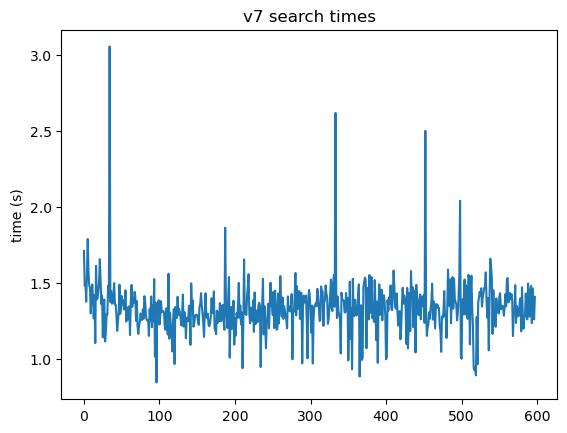

In [28]:
fig, axs = plt.subplots(1,1)
axs.plot(search_times)
axs.set_title('v7 search times')
axs.set_ylabel('time (s)')
plt.savefig('v7_search_times.pdf')

In [ ]:
for file in population_file:
    name = file
    start = name.find('0')
    end = start + 15
    mcids = name[start:end]
    print(mcids)
    outfile = f'07_sims_v7_final_mag_cut/sim_pop_{mcids}.csv'
    if os.path.exists(f'results_dir/{outfile}'):
        print(f'Files {outfile} already processed')
        continue

    with open('config.yaml') as ymlfile:
        cfg = yaml.load(ymlfile, Loader=yaml.SafeLoader)
        survey = simple_adl.survey.Survey(cfg)

    sim_population = fits.read(file)
    sim_positions = np.unique(sim_population[['RA', 'DEC']])
    sim_population  = sim_population.byteswap().newbyteorder()    # resetting byte order for compatibility
    sim_population = sim_population[sim_population['FRACDET_CORE'] == 1]
    sim_population = sim_population[sim_population['FRACDET_WIDE'] == 1]
    sim_population = sim_population[sim_population['FRACDET_HALF'] == 1]
    radius = 2

    for iii,position in enumerate(sim_positions):
        sim_population_at_position = sim_population[sim_population[['RA', 'DEC']] == position]
        t = pd.DataFrame(sim_population_at_position)
        if len(t['MC_SOURCE_ID'].values) == 0:
            print(f'No sims at {position}')
            continue
        print(f'Querying region {position}')
        real_data = query_RSP_truth(service, position[0], position[1], radius)  # pd.DataFrame

        print('Satellites at ', position, ':\n', t['MC_SOURCE_ID'].values)
        for mcid in sim_population_at_position['MC_SOURCE_ID']:
            sim_data = load_sim_data(sim_dir, mcid)
            if sim_data is not None:
                sim_data = sim_data.byteswap().newbyteorder()   # resetting byte order for compatibility
                sim_data = pd.DataFrame(sim_data)               # convert to pd.DataFrame
                # mask to ensure we only use sims within the queried data's footprint

                c2 = SkyCoord(sim_data['ra'], sim_data['dec'], unit='deg', frame='icrs')
                center = SkyCoord(position[0], position[1], unit='deg')
                d2d = center.separation(c2) 
                catalogmsk = d2d < radius*u.deg
                sim_data = sim_data[catalogmsk]

                if sim_data.empty:
                    print(f'No sim data to inject into region at ({position[0]},{position[1]}) after applying mask')
                    continue

                # merging the sims and dc2 data
                frames = [real_data[real_data.columns[:-1]], sim_data[real_data.columns[:-1]]]
                merged_data = pd.concat(frames)  # pd.Dataframe
                # perform mag cut on the merged data
                good_snr = (merged_data['magerr_g'] < 0.2) & (merged_data['magerr_r'] < 0.2)
                merged_data = merged_data[good_snr]
                good_mag = (merged_data['mag_g'] < survey.catalog['mag_max']) & (merged_data['mag_r'] < survey.catalog['mag_max'])
                merged_data = merged_data[good_mag]
                
                plots(position, real_data, sim_data, merged_data, cmap)

                print('Searching for: MC_SOURCE_ID ', mcid)

                ra = position[0]
                dec = position[1]
                region = simple_adl.survey.Region(survey, ra, dec)
                region.data = merged_data

                # Scan in distance moduli    
                distance_modulus = t.loc[t['MC_SOURCE_ID'] == mcid]['DISTANCE_MODULUS']
                distance_modulus = distance_modulus.values[0]
                iso_search = simple_adl.isochrone.Isochrone(survey=survey.isochrone['survey'],
                                                       band_1=survey.band_1.lower(),
                                                       band_2=survey.band_2.lower(),
                                                       age=12.0, #survey.isochrone['age'],
                                                       metallicity=0.00010, #survey.isochrone['metallicity'],
                                                       distance_modulus=distance_modulus)

                iso_selection = cut_isochrone_path(region.data[survey.mag_dered_1], 
                                                      region.data[survey.mag_dered_2],
                                                      region.data[survey.mag_err_1],
                                                      region.data[survey.mag_err_2],
                                                      iso_search,
                                                      survey.catalog['mag_max'],
                                                      radius=0.1)

                results = search_by_distance(survey, region, distance_modulus, iso_selection) 
                ra_peak_array, dec_peak_array, r_peak_array, sig_peak_array, distance_modulus_array, n_obs_peak_array, n_obs_half_peak_array, n_model_peak_array = np.asarray(results)
                best_ra_peak, best_dec_peak, best_r_peak, best_distance_modulus, n_obs_peak, n_obs_half_peak, n_model_peak, best_sig_peak = 0, 0, 0, 0, 0, 0, 0, 0

                if mcid: 
                    mc_source_id_array = np.full_like(distance_modulus_array, mcid)
                else:
                    mc_source_id_array = np.zeros(len(distance_modulus_array))

                # Sort peaks according to significance
                index_sort = np.argsort(sig_peak_array)[::-1]
                ra_peak_array = ra_peak_array[index_sort]
                dec_peak_array = dec_peak_array[index_sort]
                r_peak_array = r_peak_array[index_sort]
                sig_peak_array = sig_peak_array[index_sort]
                distance_modulus_array = distance_modulus_array[index_sort]
                n_obs_peak_array = n_obs_peak_array[index_sort]
                n_obs_half_peak_array = n_obs_half_peak_array[index_sort]
                n_model_peak_array = n_model_peak_array[index_sort]
                mc_source_id_array = mc_source_id_array[index_sort]

                # Collect overlapping peaks
                for ii in range(0, len(sig_peak_array)):
                    if sig_peak_array[ii] < 0:
                        continue
                    sep = angsep(ra_peak_array[ii], dec_peak_array[ii], ra_peak_array, dec_peak_array)
                    sig_peak_array[(sep < r_peak_array[ii]) & (np.arange(len(sig_peak_array)) > ii)] = -1.

                # Prune the list of peaks
                ra_peak_array = ra_peak_array[sig_peak_array > 0.]
                dec_peak_array = dec_peak_array[sig_peak_array > 0.]
                r_peak_array = r_peak_array[sig_peak_array > 0.]
                distance_modulus_array = distance_modulus_array[sig_peak_array > 0.]
                n_obs_peak_array = n_obs_peak_array[sig_peak_array > 0.]
                n_obs_half_peak_array = n_obs_half_peak_array[sig_peak_array > 0.]
                n_model_peak_array = n_model_peak_array[sig_peak_array > 0.]
                mc_source_id_array = mc_source_id_array[sig_peak_array > 0.]
                sig_peak_array = sig_peak_array[sig_peak_array > 0.] # Update the sig_peak_array last!

                if sig_peak_array[0] > best_sig_peak:
                    best_sig_peak = sig_peak_array[0]
                    best_ra_peak = ra_peak_array[0]
                    best_dec_peak = dec_peak_array[0]
                    best_r_peak = r_peak_array[0]
                    best_distance_modulus = distance_modulus_array[0]
                    n_obs_peak = n_obs_peak_array[0]
                    n_obs_half_peak = n_obs_half_peak_array[0]
                    n_model_peak = n_model_peak_array[0]
                    mc_source_id = mc_source_id_array[0]

                del merged_data
                
                for ii in range(0, len(sig_peak_array)):
                    print('{:0.2f} sigma; (RA, Dec) = ({:0.2f}, {:0.2f}); r = {:0.2f} deg; d = {:0.1f}, mu = {:0.2f} mag, mc_source_id: {:0.2f}'.format(sig_peak_array[ii], 
                             ra_peak_array[ii], 
                             dec_peak_array[ii], 
                             r_peak_array[ii],
                             distanceModulusToDistance(distance_modulus_array[ii]),
                             distance_modulus_array[ii],
                             mc_source_id_array[ii]))  

                if best_sig_peak < 9:
                    print(f'--> {mcid} NOT FOUND')
                    print('---------------------------------')
                    try:
                        if (len(sig_peak_array) > 0):
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center, best_ra_peak, best_dec_peak,
                                            best_r_peak, best_distance_modulus, 
                                            n_obs_peak, n_obs_half_peak, n_model_peak, 
                                            best_sig_peak, mcid, 0, outfile)
                        else:
                            print('No significant hotspots found.')
                            nan_array = [np.nan]
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center,
                                             nan_array, nan_array, nan_array, nan_array, 
                                             nan_array, nan_array, nan_array, nan_array,
                                             [mc_source_id], 0, outfile)
                    except Exception as e: 
                        print(e)
                        print('Data missing, cannot write to file')

                else:   
                    print(f'--> {mcid} FOUND')
                    print('---------------------------------')
                    try:
                        if (len(sig_peak_array) > 0):
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center, best_ra_peak, best_dec_peak,
                                            best_r_peak, best_distance_modulus, 
                                            n_obs_peak, n_obs_half_peak, n_model_peak, 
                                            best_sig_peak, mcid, 0, outfile)
                        else:
                            print('No significant hotspots found.')
                            nan_array = [np.nan]
                            write_output(survey.output['results_dir'], survey.catalog['nside'], region.pix_center,
                                             nan_array, nan_array, nan_array, nan_array, 
                                             nan_array, nan_array, nan_array, nan_array,
                                             [mc_source_id], 0, outfile)
                    except Exception as e: 
                        print(e)
                        print('Data missing, cannot write to file')

## Results plots

In [26]:
#setting up sim dataframe

catalog_dir = '/project/shared/data/satsim/lsst_dc2_v7' 
results_dir = 'results_dir/07_sims_v7_final_mag_cut'
simsv7 = load_simdf(catalog_dir, results_dir)

catalog_dir = '/project/shared/data/satsim/lsst_dc2_v6' 
results_dir = 'results_dir/sims_v6_final_mag_cut'
simsv6 = load_simdf(catalog_dir, results_dir)

/tmp/ipykernel_5110/1084952393.py:48: RuntimeWarning: invalid value encountered in divide
  pdet = ndet.astype(float)/total
/tmp/ipykernel_5110/1084952393.py:48: RuntimeWarning: invalid value encountered in divide
  pdet = ndet.astype(float)/total


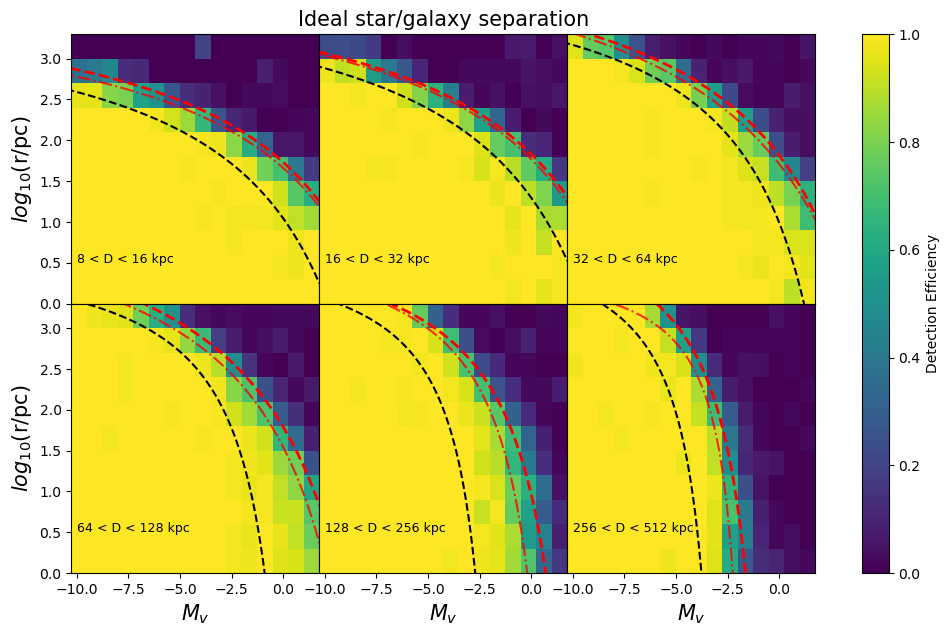

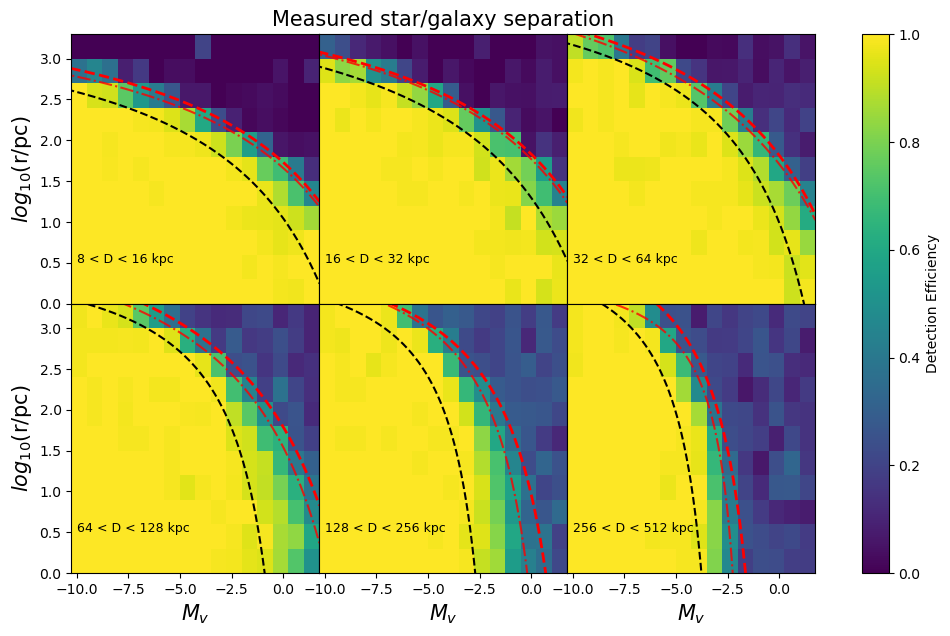

In [30]:
plot_osf(simsv7, "Ideal star/galaxy separation", save=True, out_name='quick_osfv7.jpg')
plot_osf(simsv6, "Measured star/galaxy separation", save=True, out_name='quick_osfv6.jpg')
#plot_osf(simsv6, "Measured star/galaxy separation (corrected)", save=False, out_name='measured_corr_osf.pdf', threshold=8.4)

In [55]:
help(plot_osf)

Help on function plot_osf in module __main__:

plot_osf(sims: pandas.core.frame.DataFrame, title: str, save: bool = False, out_name: str = None, contours: bool = False, survey: str = None, threshold: float = 5.5) -> None
    Plot the observational selection function
    
    parameters: 
        sims: sims dataframe
        title: title for the plot
        save: flag to save figure or not
        out_name: name of the output file if saved
        gen_contours: flag to generate 50% detection efficiency contours
        survey: survey name for efficiency contours
        
    returns: None



/tmp/ipykernel_703/1421234398.py:35: RuntimeWarning: invalid value encountered in divide
  pdet = ndet.astype(float)/total


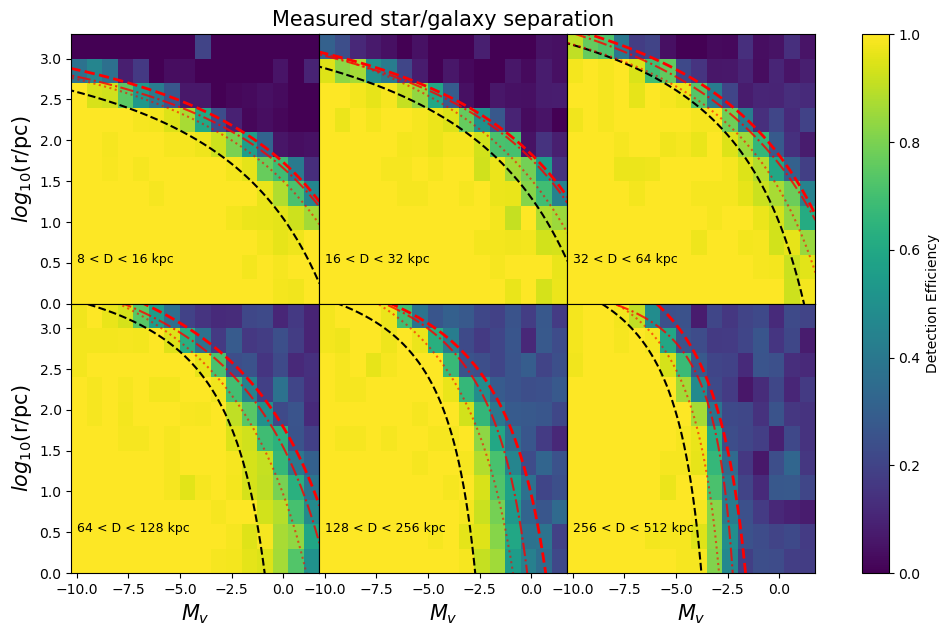

In [28]:
sims = simsv6
title = "Measured star/galaxy separation"
# bins in distance
dbins = 2**np.arange(3,10)
# bins in absolute magnitude
mbins = np.arange(-11,2.5,0.75)
# bins in physical radius
rbins = np.arange(0,3.75,0.3)

fig,axes = plt.subplots(2,3,figsize=(12,7))
plt.subplots_adjust(wspace=0, hspace=0)
axes[0,0].axes.get_xaxis().set_visible(False)
axes[0,1].axes.get_yaxis().set_visible(False)
axes[0,2].axes.get_yaxis().set_visible(False)
axes[1,2].axes.get_yaxis().set_visible(False)
axes[1,1].axes.get_yaxis().set_visible(False)
for i,(dmin,dmax) in enumerate(zip(dbins[:-1],dbins[1:])):
    plt.sca(axes.flat[i])
    plt.xlabel("$M_v$", fontsize=15)
    plt.ylabel("$log_{10}$(r/pc)", fontsize=15)
    plt.text(-10, 0.5, "%i < D < %i kpc"%(dmin,dmax), fontsize=9, )
    plt.xlim(-10.25,1.75)
    plt.ylim(0, 3.3)
    if i == 1:
        plt.title(title, fontsize=15)
    s = sims[(sims['DISTANCE'] >= dmin)&(sims['DISTANCE'] < dmax)]

    det = s["SIG"] >= 5.5

    total = np.histogram2d(s['ABS_MAG'],np.log10(s['R_PHYSICAL']*1e3),
                       bins=[mbins,rbins])[0]
    ndet = np.histogram2d(s['ABS_MAG'],np.log10(s['R_PHYSICAL']*1e3),
                       weights=det,bins=[mbins,rbins])[0]

    pdet = ndet.astype(float)/total
    im = plt.pcolormesh(mbins,rbins,pdet.T,rasterized=True)
    draw_survey(np.sqrt(dmin*dmax), survey='des', color='black')
    draw_survey(np.sqrt(dmin*dmax), survey='lsst_true', color='red', lw=2)
    draw_survey(np.sqrt(dmin*dmax), survey='lsst_measured', color='red', ls='-.', alpha=0.8)
    draw_survey(np.sqrt(dmin*dmax), survey='lsst_corrected', color='red', ls= ':', alpha=0.6)

cb = fig.colorbar(im, ax=axes.ravel().tolist(), label='Detection Efficiency')
plt.savefig("osf_measured.pdf")

In [24]:
def save_regions(path: str):
    service = get_tap_service()
    assert service is not None
    assert service.baseurl == "https://data.lsst.cloud/api/tap"
    sim_dir = '/project/shared/data/satsim/lsst_dc2_v6'
    population_file = glob.glob(os.path.join(sim_dir, '*population*'))
    with open('config.yaml') as ymlfile:
        cfg = yaml.load(ymlfile, Loader=yaml.SafeLoader)
        survey = simple_adl.survey.Survey(cfg)
        
    i = 0
    radius = 2
    for file in population_file:
        sim_population = fits.read(file)
        sim_positions = np.unique(sim_population[['RA', 'DEC']])
        for position in sim_positions:
            outfile = path + f'/region_{i}'
            if os.path.exists(outfile):
                i += 1
            else:
                print(f'Querying {position[0], position[1]}')
                real_data = query(service, position[0], position[1], radius)  # pd.DataFrame
                real_data.insert(loc=0, column='center_ra', value=position[0])
                real_data.insert(loc=1, column='center_dec', value=position[1])
                print(f'Saving region_{i}')
                real_data.to_csv(outfile)
                i += 1
            
    return
    

In [29]:
save_regions('v6_regions')

/tmp/ipykernel_703/27715484.py:2: DeprecationWarning: get_tap_service() is deprecated, use get_tap_service("tap")
  service = get_tap_service()


Querying (53.685154, -34.633377)
Saving region_2460
Querying (57.097427, -38.640705)
Saving region_2461
Querying (59.03083, -32.528732)
Saving region_2462
Querying (59.915302, -29.402332)
Saving region_2463
Querying (62.091763, -32.09003)
Saving region_2464
Querying (63.019375, -28.410015)
Saving region_2465
Querying (64.00511, -35.82566)
Saving region_2466
Querying (64.22848, -44.306187)
Saving region_2467
Querying (68.73697, -28.751019)
Saving region_2468
Querying (70.77029, -41.13887)
Saving region_2469
Querying (54.692753, -37.801594)
Saving region_2470
Querying (55.624588, -40.098892)
Saving region_2471
Querying (57.208847, -43.88984)
Saving region_2472
Querying (59.12326, -34.490005)
Saving region_2473
Querying (60.35667, -30.325357)
Saving region_2474
Querying (60.790585, -39.99504)
Saving region_2475
Querying (64.49717, -42.410614)
Saving region_2476
Querying (67.97919, -37.56191)
Saving region_2477
Querying (69.458626, -42.000736)
Saving region_2478
Querying (69.79423, -30.672

KeyboardInterrupt: 

In [30]:
def func(x,a,b,c):
    return a/(x - b) + c

In [31]:
# Initial guess
P0=[[11.3 ,  10.0 ,  4.0  ],
    [22.6 ,  10.0 ,  4.3  ],
    [45.2 ,  6.0  ,  4.3  ],
    [90.5 ,  4.7  ,  4.3  ],
    [181.0,  2.1  ,  4.3  ],
    [362.0,  -0.7 ,  4.6  ],]

BOUNDS = [[0, -10, 3.5], #lower bounds for each column
          [512, 10, 5.0]] #upper bounds for each column

files = sorted(glob.glob('lsst_corrected_p50_d*.npy'))
results = []

for i,f in enumerate(files):
    dist = float(f.rsplit('_')[-1].rsplit('.',1)[0].strip('d'))
    data = np.load(f)
    sigma = 0.05*np.ones(len(data[:,1]))
    sigma[0] = 0.5
    sigma[-1] = 0.5
    #print sigma
    r = curve_fit(func,data[:,0],data[:,1],p0=P0[i],sigma=sigma,bounds=BOUNDS)
    results += [[dist]+r[0].tolist()]

results = np.asarray(results)
results = results[np.argsort(results[:,0])]

print('%-5s  %-5s  %-5s  %-5s'%('Dist','A0','Mv0','logr0'))
for r in results:
    print('[%-5.1f,  %-5.1f,  %-5.1f,  %-5.1f],'%tuple(r))

Dist   A0     Mv0    logr0
[11.3 ,  25.0 ,  10.0 ,  4.0  ],
[22.6 ,  30.8 ,  10.0 ,  4.6  ],
[45.2 ,  20.7 ,  6.9  ,  4.4  ],
[90.5 ,  23.4 ,  5.8  ,  5.0  ],
[181.0,  14.3 ,  2.1  ,  4.8  ],
[362.0,  6.5  ,  -1.4 ,  4.3  ],


## Calculating PDet values

In [59]:
importlib.reload(selection_function)
importlib.reload(sc_utils)

<module 'dc2_satellite_census.code.utils' from '/home/kb/software/dc2_satellite_census/code/utils.py'>

In [60]:
ssf = selection_function.SurveySelectionFunction('config.yaml')

Loading /home/kb/lsst_wfd_toy.fits...


In [61]:
ssf.train_classifier()

Ntrain =  54116; Ntest = 6013 
Training XGBClassifier...
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/home/kb/software/dc2_satellite_census/code/utils.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SIG'][data['DIFFICULTY'] == 1] = np.nan
/home/kb/software/dc2_satellite_census/code/utils.py:382: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['SIG'][data['DIFFICULTY'] == 2] = 99
/home/kb/.conda/envs/simple/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/kb/.conda/envs/simple/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_spa

{'learning_rate': 0.05, 'max_delta_step': 1, 'max_depth': 7, 'n_estimators': 100, 'seed': 1337}
  ... training took 359.45 seconds


In [75]:
pdet = ssf.predict_proba(distance=2, r_physical=0.1, abs_mag=10)
pdet

array([0.3065494 , 0.8692688 , 0.87385255, ..., 0.07808335, 0.18246947,
       0.9661026 ], dtype=float32)

In [71]:
x_eval

array([[ 2., 10., -1.]])

In [72]:
help(np.vstack)

Help on _ArrayFunctionDispatcher in module numpy:

vstack(tup, *, dtype=None, casting='same_kind')
    Stack arrays in sequence vertically (row wise).

    This is equivalent to concatenation along the first axis after 1-D arrays
    of shape `(N,)` have been reshaped to `(1,N)`. Rebuilds arrays divided by
    `vsplit`.

    This function makes most sense for arrays with up to 3 dimensions. For
    instance, for pixel-data with a height (first axis), width (second axis),
    and r/g/b channels (third axis). The functions `concatenate`, `stack` and
    `block` provide more general stacking and concatenation operations.

    ``np.row_stack`` is an alias for `vstack`. They are the same function.

    Parameters
    ----------
    tup : sequence of ndarrays
        The arrays must have the same shape along all but the first axis.
        1-D arrays must have the same length.

    dtype : str or dtype
        If provided, the destination array will have this dtype. Cannot be
        provide

In [47]:
map = healsparse.HealSparseMap.read('3-3_10_year_depth_g_nside_128.hs')
hp_map = map.generate_healpix_map(nside=128)

In [86]:
ssf.mask

HealSparseMap: nside_coverage = 32, nside_sparse = 128, float32, 133949 valid pixels

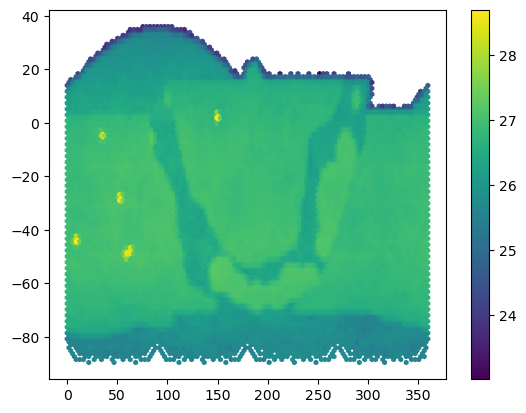

In [39]:
# Visualization of the map
vpix, ra, dec = map.valid_pixels_pos(return_pixels=True)
plt.hexbin(ra, dec, C=map[vpix])
plt.colorbar()
plt.show()

(<matplotlib.collections.QuadMesh at 0x7e5981c676b0>,
 array([[-180.        , -179.63963965, -179.2792793 , ...,  179.2792693 ,
          179.63962965,  179.99999   ],
        [-180.        , -179.63963965, -179.2792793 , ...,  179.2792693 ,
          179.63962965,  179.99999   ],
        [-180.        , -179.63963965, -179.2792793 , ...,  179.2792693 ,
          179.63962965,  179.99999   ],
        ...,
        [-180.        , -179.63963965, -179.2792793 , ...,  179.2792693 ,
          179.63962965,  179.99999   ],
        [-180.        , -179.63963965, -179.2792793 , ...,  179.2792693 ,
          179.63962965,  179.99999   ],
        [-180.        , -179.63963965, -179.2792793 , ...,  179.2792693 ,
          179.63962965,  179.99999   ]]),
 array([[-89.99999   , -89.99999   , -89.99999   , ..., -89.99999   ,
         -89.99999   , -89.99999   ],
        [-89.81980984, -89.81980984, -89.81980984, ..., -89.81980984,
         -89.81980984, -89.81980984],
        [-89.63962968, -89.6396

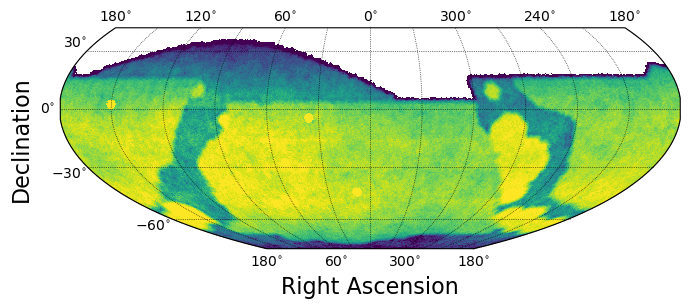

In [71]:
hspmap=hsp.HealSparseMap.read('3-3_10_year_depth_g_nside_128.hs')
# if you want a healpix map hspmap.generate_healpix_map()
fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
# Note that the default is to zoom in to the range defined by the map
sp.draw_hspmap(ssf.mask)
plt.colorbar(label="g-band depth", orientation="horizontal")
plt.title("baseline 3.3 10 year depth", y=1.05)

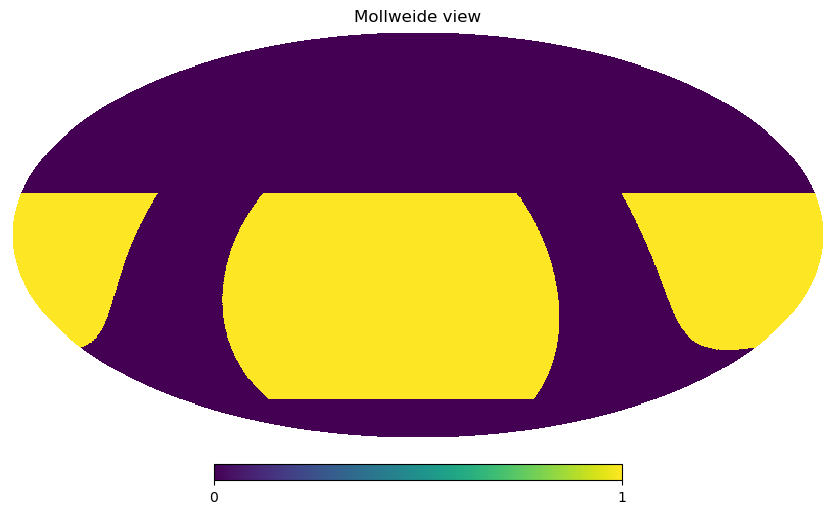

In [91]:
map = hp.read_map('lsst_wfd_toy.fits')
hp.mollview(map)

Text(0.5, 1.05, 'baseline 3.3 10 year depth')

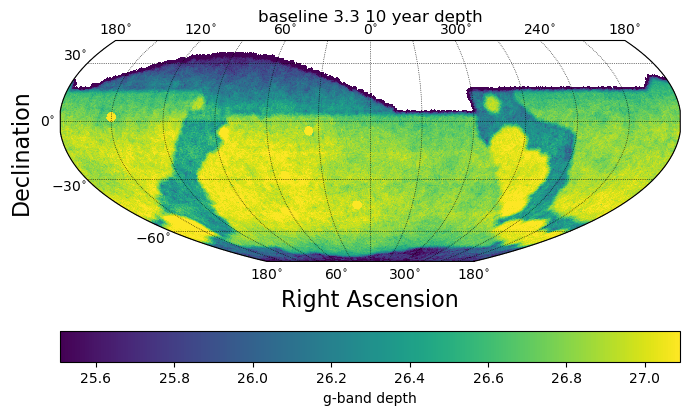

In [92]:
fig = plt.figure(1, figsize=(8, 6))
fig.clf()
ax = fig.add_subplot(111)
sp = skyproj.McBrydeSkyproj(ax=ax)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(ssf.mask)
plt.colorbar(label="g-band depth", orientation="horizontal")
plt.title("baseline 3.3 10 year depth", y=1.05)